In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, resnet34
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, AdamW
import torchvision.transforms as transforms
from transformers import get_linear_schedule_with_warmup

import os
from tqdm import tqdm

In [14]:
class CAPTCHADataset(Dataset):
    def __init__(self,  dir, label_file, label_map, transform=None, subset_qty=None):
        super(CAPTCHADataset, self).__init__()
        
        self.dir = dir
        self.label_file = pd.read_csv(os.path.join(os.path.curdir, label_file))
        if subset_qty != None:
            self.label_file = self.label_file.sample(subset_qty, axis=0).reset_index()
        self.label_map = label_map
        self.transform = transform

    def __getitem__(self, index):
        image_name = self.label_file['image'][index]
        image = Image.open(os.path.join(os.getcwd(), self.dir, image_name))
        
        label = self.label_file['label'][index]
        
        if self.transform != None:
            image = self.transform(image)
        
        numeric_label = self.label_map[label]
        
        return image, numeric_label
    
    def __len__(self):
        return len(self.label_file)

In [15]:
labels = pd.read_csv('hard_set_labels.csv')['label'].unique().tolist()
print(len(labels))

numeric_labels = range(len(labels))

label_map = dict(zip(labels, numeric_labels))

98


In [16]:
train_transforms = transforms.Compose([

                                        transforms.Resize((150, 300)),
                                        transforms.RandomRotation(25),
                                        transforms.ColorJitter(saturation=[5, 15], hue=[-0.2, 0.2]),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[1.848086931276295, 1.8482869967014623, 1.848101962198446],
                                                             std = [0.319237245924657, 0.31864693591324456, 0.31901034284562513])
                                            ])

test_transforms = transforms.Compose([

                                        transforms.Resize((150, 300)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[1.848086931276295, 1.8482869967014623, 1.848101962198446],
                                                             std = [0.319237245924657, 0.31864693591324456, 0.31901034284562513])
                                            ])


In [ ]:
generator = torch.Generator().manual_seed(42)
subset_size = 25000
# subset_indices = torch.randint(low=0, high=25000, size=(subset_size,))

easy_set = CAPTCHADataset(dir='old_data/easy_set', label_file='old_data/easy_set_labels.csv', label_map=label_map, transform=train_transforms, subset_qty=16000)
easy_set_train, easy_set_test = torch.utils.data.random_split(easy_set, lengths=[0.8, 0.2], generator=generator)
# easy_set_train = torch.utils.data.Subset(easy_set_train, subset_indices)

hard_set = CAPTCHADataset(dir='old_data/hard_set', label_file='old_data/hard_set_labels.csv', label_map=label_map, transform=train_transforms, subset_qty=4000)
hard_set_train, hard_set_test = torch.utils.data.random_split(hard_set, lengths=[0.8, 0.2], generator=generator)
# easy_set_train = torch.utils.data.Subset(easy_set_train, subset_indices)

train_data = torch.utils.data.ConcatDataset([easy_set_train, hard_set_train])
test_data = torch.utils.data.ConcatDataset([easy_set_test, hard_set_test])

print("Number of training samples: ", len(train_data))
print("Number of testing samples: ", len(test_data))
print("Number of Easy train samples: ", len(easy_set_train)) 
print("Number of Hard train samples: ", len(hard_set_train))
print("Number of Easy test samples: ", len(easy_set_test)) 
print("Number of Hard test samples: ", len(hard_set_test))
print("Number of Classes: ", len(labels))

Number of training samples:  16000
Number of testing samples:  4000
Number of Easy train samples:  12800
Number of Hard train samples:  3200
Number of Easy test samples:  3200
Number of Hard test samples:  800
Number of Classes:  98


In [50]:
trainloader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=18)
testloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=18)

In [51]:
def train(model, dataloader, optimizer, scheduler):
    
    running_loss = 0.0
    nb_steps = 0
    
    for batch in tqdm(dataloader):
        images, labels = batch
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        logits = model(images)
        curr_loss = loss_fn(logits, labels)
        
        curr_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler != None:
            scheduler.step()
        
        running_loss += curr_loss
        nb_steps += 1
    
    return running_loss / nb_steps

In [52]:
def accuracy(logits, labels):
    predictions = torch.argmax(logits, dim=-1)
    
    assert len(predictions) == len(labels), "shape of predictions and labels do not match"
    
    return (torch.sum(predictions == labels).item()) / len(labels)

def evaluate(model, dataloader):
    running_loss, running_acc = 0.0, 0.0
    nb_steps = 0
    
    for batch in dataloader:
        images, labels = batch
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.no_grad():
            logits = model(images)
        curr_loss = loss_fn(logits, labels)
        curr_acc = accuracy(logits, labels) 
        
        running_loss += curr_loss
        running_acc += curr_acc
        
        nb_steps += 1
    
    return (running_loss / nb_steps, running_acc/nb_steps)

In [53]:
def run(epochs, model, optimizer, scheduler, trainloader, testloader, save_dir):
    
    best_acc = 0
    
    train_losses, val_losses, val_acc = [], [], []
    
    print("Training started.")
    for epoch in range(epochs):
        print("=======================================================")
        print(f"Epoch {epoch}/{epochs}")
        
        train_loss = train(model, trainloader, optimizer, scheduler)
        print(f"Train loss: {train_loss}", end='\t\t')
        
        val_loss, acc = evaluate(model, testloader)
        print(f"Validation loss: {val_loss}", end='\t\t')
        print(f"Validation accuracy: {acc}")
        
        if acc > best_acc:
            print("Better model state found. Saving ...")
            torch.save(model.state_dict(), os.path.join('/home/swapnanil_mukherjee/captcha/checkpoints/', save_dir, "best_model.pth"))
            
            best_acc = acc
        
        train_losses.append(train_loss.cpu().item())
        val_losses.append(val_loss.cpu().item())
        val_acc.append(acc)
        
    return train_losses, val_losses, val_acc

In [54]:
loss_fn = torch.nn.CrossEntropyLoss()
device = "cuda"

In [55]:
import torch
import torch.nn as nn
from timm.layers import DropPath

class ConvNeXtCAPTCHA(nn.Module):
    def __init__(self, num_classes=1000, 
                 depths=[3, 3, 9, 3], 
                 dims= [32, 64, 128, 256],
                 drop_path_rate=0.1):
        super().__init__()
        
        # Stem: 4x4 non-overlapping convolution
        self.stem = nn.Sequential(
            nn.Conv2d(3, dims[0], kernel_size=4, stride=4),
            nn.GroupNorm(1, dims[0])  # Temporary normalization
        )
        
        # Feature pyramid stages
        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        
        # Build hierarchical stages with proper normalization
        for i in range(4):
            stage = nn.Sequential(
                *[ConvNeXtBlock(dim=dims[i], 
                  drop_path=dp_rates[cur + j],
                  layer_scale=1e-6) 
                for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]
            
            if i < 3:  # Downsample between stages
                self.stages.append(nn.Sequential(
                    nn.GroupNorm(1, dims[i]),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
                ))
        
        # Final normalization and head
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = nn.Linear(dims[-1], num_classes)
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.trunc_normal_(m.weight, std=0.02)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Input shape: (B, 3, H, W)
        x = self.stem(x)  # (B, C, H/4, W/4)
        
        for stage in self.stages:
            x = stage(x)
            
        # Global average pooling
        x = x.mean([-2, -1])  # (B, C)
        x = self.norm(x)
        return self.head(x)

class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale=1e-6):
        super().__init__()
        # Depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        
        # Normalization AFTER depthwise conv (channel-first format)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        
        # Pointwise expansions
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        
        # Layer scale and drop path
        self.gamma = nn.Parameter(layer_scale * torch.ones(dim)) if layer_scale > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()

    def forward(self, x):
        input = x
        
        # Depthwise convolution (channel-first)
        x = self.dwconv(x)
        
        # Permute to channel-last for LayerNorm
        x = x.permute(0, 2, 3, 1)  # (B, H, W, C)
        x = self.norm(x)
        
        # Pointwise expansions
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        
        # Layer scale
        if self.gamma is not None:
            x = self.gamma * x
            
        # Permute back to channel-first
        x = x.permute(0, 3, 1, 2)  # (B, C, H, W)
        
        # Residual connection
        x = input + self.drop_path(x)
        return x

In [56]:
epochs = 50
# model = vgg16(weights=None, num_classes=98).to(device)
model = ConvNeXtCAPTCHA(num_classes=98).to(device)

optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_training_steps=len(trainloader)*epochs, 
                                            num_warmup_steps=len(trainloader)*epochs*0.1)

train_losses, val_losses, val_acc = run(epochs, model, optimizer, scheduler, trainloader, testloader, save_dir="vgg")

Training started.
Epoch 0/50


100%|██████████| 250/250 [00:18<00:00, 13.50it/s]

Train loss: 4.658642768859863		

Validation loss: 4.596151828765869		Validation accuracy: 0.015873015873015872
Better model state found. Saving ...
Epoch 1/50


100%|██████████| 250/250 [00:18<00:00, 13.47it/s]

Train loss: 4.590627670288086		

Validation loss: 4.594672679901123		Validation accuracy: 0.017609126984126984
Better model state found. Saving ...
Epoch 2/50


100%|██████████| 250/250 [00:18<00:00, 13.45it/s]

Train loss: 4.5899763107299805		

Validation loss: 4.592101097106934		Validation accuracy: 0.01711309523809524
Epoch 3/50


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]

Train loss: 4.58868408203125		

Validation loss: 4.584519863128662		Validation accuracy: 0.01711309523809524
Epoch 4/50


100%|██████████| 250/250 [00:18<00:00, 13.51it/s]

Train loss: 4.366670608520508		

Validation loss: 3.712364912033081		Validation accuracy: 0.1661706349206349
Better model state found. Saving ...
Epoch 5/50


100%|██████████| 250/250 [00:18<00:00, 13.35it/s]

Train loss: 2.812859058380127		

Validation loss: 2.087473154067993		Validation accuracy: 0.7041170634920635
Better model state found. Saving ...
Epoch 6/50


100%|██████████| 250/250 [00:18<00:00, 13.52it/s]


Train loss: 1.6309421062469482		Validation loss: 1.2956748008728027		Validation accuracy: 0.8003472222222222
Better model state found. Saving ...
Epoch 7/50


100%|██████████| 250/250 [00:18<00:00, 13.28it/s]

Train loss: 1.1164517402648926		

Validation loss: 1.0331361293792725		Validation accuracy: 0.8112599206349206
Better model state found. Saving ...
Epoch 8/50


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]

Train loss: 0.9456639885902405		

Validation loss: 0.9179774522781372		Validation accuracy: 0.8194444444444444
Better model state found. Saving ...
Epoch 9/50


100%|██████████| 250/250 [00:18<00:00, 13.29it/s]

Train loss: 0.8565348386764526		

Validation loss: 0.8300482034683228		Validation accuracy: 0.8226686507936508
Better model state found. Saving ...
Epoch 10/50


100%|██████████| 250/250 [00:18<00:00, 13.38it/s]

Train loss: 0.790791928768158		

Validation loss: 0.7993093132972717		Validation accuracy: 0.8266369047619048
Better model state found. Saving ...
Epoch 11/50


100%|██████████| 250/250 [00:18<00:00, 13.32it/s]

Train loss: 0.7372706532478333		

Validation loss: 0.7332462668418884		Validation accuracy: 0.8358134920634921
Better model state found. Saving ...
Epoch 12/50


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]

Train loss: 0.6901071071624756		

Validation loss: 0.7202231884002686		Validation accuracy: 0.8380456349206349
Better model state found. Saving ...
Epoch 13/50


100%|██████████| 250/250 [00:18<00:00, 13.37it/s]

Train loss: 0.6501128077507019		

Validation loss: 0.6799121499061584		Validation accuracy: 0.8425099206349206
Better model state found. Saving ...
Epoch 14/50


100%|██████████| 250/250 [00:18<00:00, 13.36it/s]

Train loss: 0.6080242395401001		

Validation loss: 0.6285791397094727		Validation accuracy: 0.8509424603174603
Better model state found. Saving ...
Epoch 15/50


100%|██████████| 250/250 [00:18<00:00, 13.29it/s]

Train loss: 0.5689930319786072		

Validation loss: 0.6224848031997681		Validation accuracy: 0.8524305555555556
Better model state found. Saving ...
Epoch 16/50


100%|██████████| 250/250 [00:18<00:00, 13.38it/s]

Train loss: 0.5336765050888062		

Validation loss: 0.6051769256591797		Validation accuracy: 0.8544146825396826
Better model state found. Saving ...
Epoch 17/50


100%|██████████| 250/250 [00:18<00:00, 13.41it/s]

Train loss: 0.502535343170166		

Validation loss: 0.547529399394989		Validation accuracy: 0.8680555555555556
Better model state found. Saving ...
Epoch 18/50


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]

Train loss: 0.4742681384086609		

Validation loss: 0.5471758246421814		Validation accuracy: 0.8670634920634921
Epoch 19/50


100%|██████████| 250/250 [00:19<00:00, 13.12it/s]

Train loss: 0.4412790536880493		

Validation loss: 0.5213537812232971		Validation accuracy: 0.8722718253968254
Better model state found. Saving ...
Epoch 20/50


100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


Train loss: 0.4163103699684143		Validation loss: 0.4937751591205597		Validation accuracy: 0.8792162698412699
Better model state found. Saving ...
Epoch 21/50


100%|██████████| 250/250 [00:18<00:00, 13.47it/s]

Train loss: 0.3866068422794342		

Validation loss: 0.4872235655784607		Validation accuracy: 0.8861607142857143
Better model state found. Saving ...
Epoch 22/50


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]

Train loss: 0.3672855496406555		

Validation loss: 0.45070064067840576		Validation accuracy: 0.8908730158730159
Better model state found. Saving ...
Epoch 23/50


100%|██████████| 250/250 [00:18<00:00, 13.30it/s]

Train loss: 0.34695202112197876		

Validation loss: 0.43528032302856445		Validation accuracy: 0.8936011904761905
Better model state found. Saving ...
Epoch 24/50


100%|██████████| 250/250 [00:18<00:00, 13.29it/s]

Train loss: 0.3244357705116272		

Validation loss: 0.42651882767677307		Validation accuracy: 0.8911210317460317
Epoch 25/50


100%|██████████| 250/250 [00:18<00:00, 13.35it/s]

Train loss: 0.3060421049594879		

Validation loss: 0.4285132884979248		Validation accuracy: 0.8955853174603174
Better model state found. Saving ...
Epoch 26/50


100%|██████████| 250/250 [00:18<00:00, 13.31it/s]

Train loss: 0.28586694598197937		

Validation loss: 0.3875412940979004		Validation accuracy: 0.904265873015873
Better model state found. Saving ...
Epoch 27/50


100%|██████████| 250/250 [00:18<00:00, 13.30it/s]

Train loss: 0.258823037147522		

Validation loss: 0.38080576062202454		Validation accuracy: 0.9084821428571429
Better model state found. Saving ...
Epoch 28/50


100%|██████████| 250/250 [00:18<00:00, 13.33it/s]

Train loss: 0.25451257824897766		

Validation loss: 0.37327122688293457		Validation accuracy: 0.9099702380952381
Better model state found. Saving ...
Epoch 29/50


100%|██████████| 250/250 [00:18<00:00, 13.38it/s]

Train loss: 0.23601225018501282		

Validation loss: 0.36014971137046814		Validation accuracy: 0.908234126984127
Epoch 30/50


100%|██████████| 250/250 [00:18<00:00, 13.40it/s]


Train loss: 0.2191140055656433		Validation loss: 0.3443964421749115		Validation accuracy: 0.9104662698412699
Better model state found. Saving ...
Epoch 31/50


100%|██████████| 250/250 [00:18<00:00, 13.30it/s]

Train loss: 0.20976877212524414		

Validation loss: 0.32673391699790955		Validation accuracy: 0.9203869047619048
Better model state found. Saving ...
Epoch 32/50


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]

Train loss: 0.1956220418214798		

Validation loss: 0.3161405324935913		Validation accuracy: 0.9236111111111112
Better model state found. Saving ...
Epoch 33/50


100%|██████████| 250/250 [00:18<00:00, 13.34it/s]


Train loss: 0.18395107984542847		Validation loss: 0.32316723465919495		Validation accuracy: 0.9164186507936508
Epoch 34/50


100%|██████████| 250/250 [00:18<00:00, 13.28it/s]

Train loss: 0.1789739429950714		

Validation loss: 0.2981487512588501		Validation accuracy: 0.9273313492063492
Better model state found. Saving ...
Epoch 35/50


100%|██████████| 250/250 [00:18<00:00, 13.36it/s]

Train loss: 0.16340984404087067		

Validation loss: 0.2977266013622284		Validation accuracy: 0.9265873015873016
Epoch 36/50


100%|██████████| 250/250 [00:18<00:00, 13.35it/s]

Train loss: 0.15832732617855072		

Validation loss: 0.2752709686756134		Validation accuracy: 0.9300595238095238
Better model state found. Saving ...
Epoch 37/50


100%|██████████| 250/250 [00:18<00:00, 13.32it/s]

Train loss: 0.1496700942516327		

Validation loss: 0.2842583954334259		Validation accuracy: 0.9295634920634921
Epoch 38/50


100%|██████████| 250/250 [00:18<00:00, 13.26it/s]

Train loss: 0.1460517793893814		

Validation loss: 0.28926169872283936		Validation accuracy: 0.9283234126984127
Epoch 39/50


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]

Train loss: 0.13236014544963837		

Validation loss: 0.26430222392082214		Validation accuracy: 0.933531746031746
Better model state found. Saving ...
Epoch 40/50


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]

Train loss: 0.12237773090600967		

Validation loss: 0.26230016350746155		Validation accuracy: 0.9370039682539683
Better model state found. Saving ...
Epoch 41/50


100%|██████████| 250/250 [00:19<00:00, 13.03it/s]

Train loss: 0.11981229484081268		

Validation loss: 0.2593643367290497		Validation accuracy: 0.9325396825396826
Epoch 42/50


100%|██████████| 250/250 [00:18<00:00, 13.39it/s]

Train loss: 0.11314941197633743		

Validation loss: 0.24975082278251648		Validation accuracy: 0.9424603174603174
Better model state found. Saving ...
Epoch 43/50


100%|██████████| 250/250 [00:18<00:00, 13.28it/s]

Train loss: 0.10921085625886917		

Validation loss: 0.2538079619407654		Validation accuracy: 0.9399801587301587
Epoch 44/50


100%|██████████| 250/250 [00:18<00:00, 13.46it/s]

Train loss: 0.1083294153213501		

Validation loss: 0.25601908564567566		Validation accuracy: 0.9387400793650794
Epoch 45/50


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]

Train loss: 0.10588546842336655		

Validation loss: 0.2574894428253174		Validation accuracy: 0.9372519841269841
Epoch 46/50


100%|██████████| 250/250 [00:18<00:00, 13.33it/s]

Train loss: 0.10244732350111008		

Validation loss: 0.24233990907669067		Validation accuracy: 0.9424603174603174
Epoch 47/50


100%|██████████| 250/250 [00:19<00:00, 13.14it/s]


Train loss: 0.09886114299297333		Validation loss: 0.24893788993358612		Validation accuracy: 0.9404761904761905
Epoch 48/50


100%|██████████| 250/250 [00:18<00:00, 13.20it/s]

Train loss: 0.09260623902082443		

Validation loss: 0.24001453816890717		Validation accuracy: 0.9412202380952381
Epoch 49/50


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]

Train loss: 0.09481963515281677		

Validation loss: 0.23727136850357056		Validation accuracy: 0.9427083333333334
Better model state found. Saving ...


In [ ]:
# number of parameters in the model (millions)
sum(p.numel() for p in model.parameters()) / 10**6

3.203714

<function matplotlib.pyplot.show(close=None, block=None)>

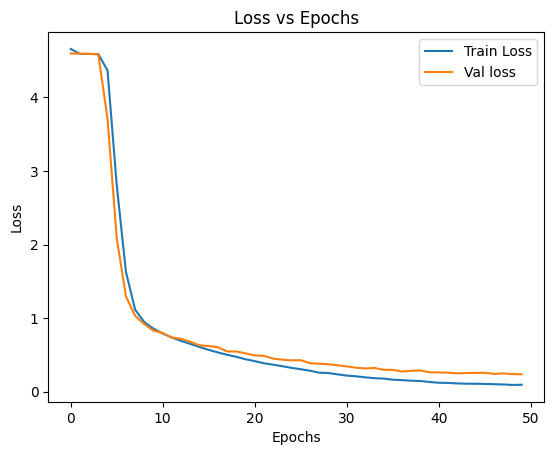

In [57]:
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label= 'Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

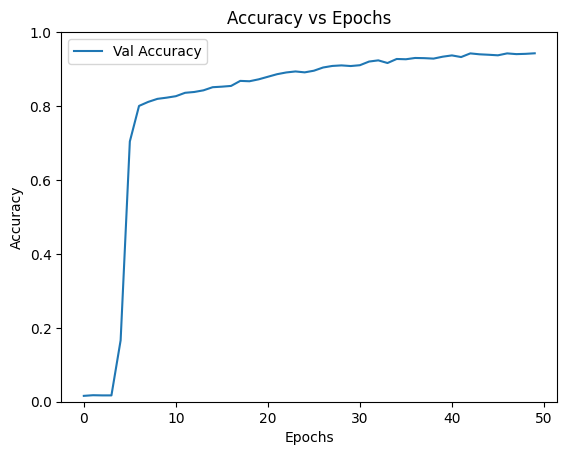

In [58]:
plt.plot(range(epochs), val_acc, label= 'Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.ylim(0, 1)
plt.legend()
plt.show